# Global Societal Endangerment Index (GSEI)

Development notebook for step 3: Missing Data Imputation

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

In [3]:
dfc = pd.read_csv("data/processing/selected_all_data.csv")
df = dfc.drop(columns=['Country'])

dfc#.head(10)

,Country,Temp Change max 2012-2022,Disaster Affected Population 2020-2025,Disaster Damage US$T 2020-2025,"Unsafe water, sanitation (YLL)",Air pollution (YLL),Safe Drinking Water (%),Food Insecurity (%),Undernourishment (%),Renewable Freshwater per Capita (m3),...,Renewable Energy Consumption (%),Internet Users (%),Secure Internet Servers,Future Conflict Risk,Current Conflict Intensity,COVID-19 Expenditure per Capita (US$),Prevalence HIV/AIDS,Prevalence TB/Respiratory,Prevalence Malaria/Tropical,Prevalence Other Infectious
0,Afghanistan,2.012,13016058.0,0.000000e+00,1422.29,4283.98,30.034098,80.9,30.4,1178.737859,...,20.0,NaN,43.758544,0.922130,335.0,2.0,13.08,20436.28,22050.99,1619.54
1,Angola,1.752,4544311.0,0.000000e+00,1710.48,2429.79,NaN,79.2,23.2,4285.826520,...,52.9,39.2935,40.217790,0.346535,0.0,NaN,1461.24,33231.90,38007.20,2256.36
2,Albania,2.028,84.0,0.000000e+00,26.79,1660.57,70.736068,32.2,4.5,9567.281462,...,41.9,82.6137,1220.332909,0.007443,0.0,NaN,1.07,22568.22,903.34,1063.17
3,Andorra,3.243,NaN,NaN,2.19,239.38,90.640001,NaN,NaN,4027.359502,...,18.4,94.4855,14618.581181,NaN,NaN,NaN,53.38,12313.50,234.83,385.35
4,United Arab Emirates,1.699,346.0,0.000000e+00,9.79,618.65,NaN,10.0,2.7,15.665548,...,1.0,100.0000,2119.661179,0.009810,0.0,379.0,31.04,31692.01,4985.35,1077.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,Samoa,1.440,NaN,NaN,109.99,3146.24,62.191714,23.6,5.4,NaN,...,36.0,75.2869,618.472005,0.000000,0.0,NaN,117.76,35473.22,15081.71,1656.79
188,Yemen,NaN,1885344.0,2.354600e+07,471.74,2859.66,NaN,72.5,39.5,56.542461,...,3.7,17.6948,6.955939,0.991317,910.0,NaN,34.39,22014.70,18266.55,2882.38
189,South Africa,1.811,12286813.0,3.910613e+09,1360.48,1806.03,NaN,19.4,8.1,728.424454,...,9.7,74.7030,14786.991739,0.440710,5.0,NaN,16048.52,48386.80,17584.37,1642.94
190,Zambia,1.450,12283962.0,0.000000e+00,1903.05,3103.66,NaN,NaN,35.4,4091.083850,...,83.0,31.2342,54.960525,0.022211,0.0,NaN,7017.77,25620.10,33173.61,3178.97


In [4]:
# create a mask for missing values
missing_mask = df.isnull()

# statistic for missing values
columns_to_impute = df.isna().sum()[df.isna().sum() > 0].reset_index()
columns_to_impute.columns = ['Feature', 'Missing']

print('Missing values:', columns_to_impute['Missing'].sum())
print('Percentage of missing values:', columns_to_impute['Missing'].sum() / df.size)

columns_to_impute

Missing values: 1535
Percentage of missing values: 0.19035218253968253


,Feature,Missing
0,Temp Change max 2012-2022,7
1,Disaster Affected Population 2020-2025,19
2,Disaster Damage US$T 2020-2025,19
3,Safe Drinking Water (%),73
4,Food Insecurity (%),42
5,Undernourishment (%),26
6,Renewable Freshwater per Capita (m3),12
7,"Democracy, not Autocracy",21
8,Population below Poverty Line (%),121
9,Health Expenditure per Capita (US$),4


## Imputation based on Clustering

Cluster similar countries and impute the cluster means.


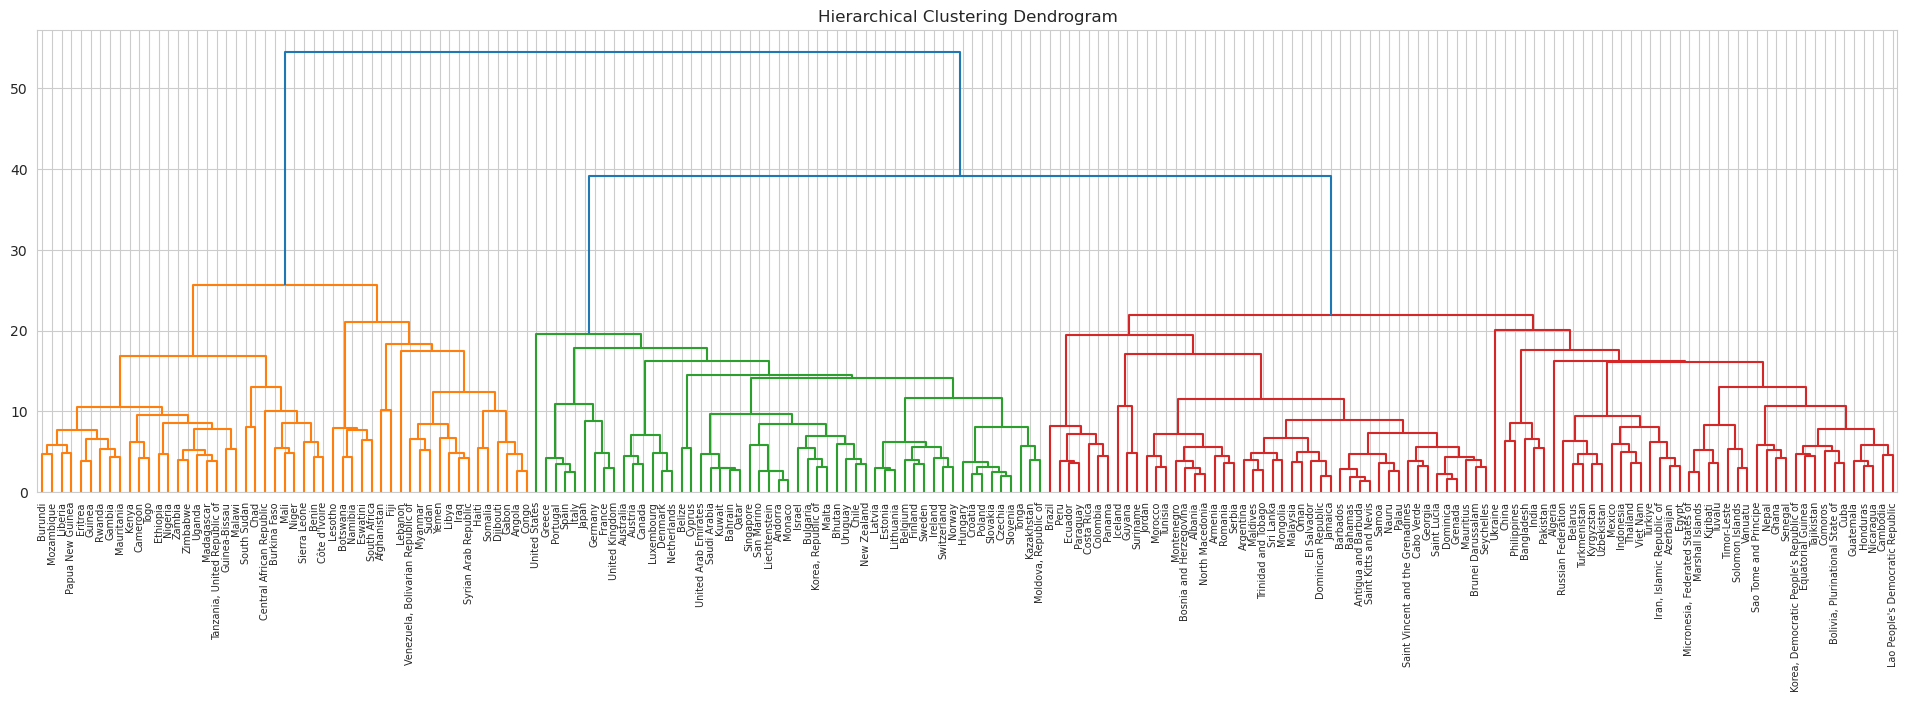

In [5]:
# handle missing values (temporarily fill with column means)
df_filled = df.apply(lambda x: x.fillna(x.mean()), axis=0)

# normalize the data (robust standardisation)
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_filled), columns=df.columns)

# hierarchical clustering
Z = linkage(df_scaled, method='ward')  # 'ward' minimizes variance within clusters

# show dendrogram
plt.figure(figsize=(24, 6))
dendrogram(Z, leaf_rotation=90, leaf_font_size=7, labels=dfc['Country'].values)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()

In [6]:
# decide on number of clusters based on dendrogram
num_clusters = 5
clusters = fcluster(Z, num_clusters, criterion='maxclust')

# impute missing values based on cluster means
df_imputed = df.copy()
df_imputed.insert(0, 'Cluster', clusters)

for col in df_imputed.columns[1:]:
    df_imputed[col] = df_imputed.groupby('Cluster')[col].transform(lambda x: x.fillna(x.mean()))

# check cluster sizes
df_imputed['Cluster'].value_counts()

Cluster
3    53
4    46
5    42
1    30
2    21
Name: count, dtype: int64

In [7]:
# check if values are missing for whole clusters
still_missing = df_imputed.isnull().sum()
still_missing = still_missing[still_missing > 0].reset_index()
still_missing.columns = ['Feature', 'Missing']

missing_clusters = []
for v in still_missing['Feature']:
    # find first row and take cluster number
    cluster = df_imputed[df_imputed[v].isnull()].iloc[0]['Cluster']
    missing_clusters.append(cluster)
still_missing['Cluster'] = missing_clusters

still_missing

,Feature,Missing,Cluster
0,Population below Poverty Line (%),21,2.0
1,Gini Coefficient,21,2.0
2,Income Share Top 10%,21,2.0


In [8]:
# take global mean for still missing values
df_imputed2 = df_imputed.fillna(df_imputed.mean())

In [9]:
# show whole dataframe with imputed columns
#pd.concat([dfc['Country'], df_imputed2], axis=1).filter(['Country','Cluster'] + columns_to_impute['Feature'].tolist())

In [10]:
# display imputed values to check for issues
diff_df = df_imputed2.copy()
diff_df.drop(columns=["Cluster"], inplace=True)

# append the values that were imputed with "(imp.)".
for column in diff_df.columns:
    diff_df[column] = diff_df.apply(lambda row: row[column] if not missing_mask.loc[row.name, column] else f"{row[column]} (imp.)", axis=1)

# sort by cluster
pd.concat([dfc['Country'], df_imputed2['Cluster'], diff_df[columns_to_impute['Feature']]], axis=1).sort_values(by='Cluster')

,Country,Cluster,Temp Change max 2012-2022,Disaster Affected Population 2020-2025,Disaster Damage US$T 2020-2025,Safe Drinking Water (%),Food Insecurity (%),Undernourishment (%),Renewable Freshwater per Capita (m3),"Democracy, not Autocracy",...,Gini Coefficient,Income Share Top 10%,Inflation (%),Unemployment (%),Youth Unemployment (%),Renewable Energy Consumption (%),Internet Users (%),Future Conflict Risk,Current Conflict Intensity,COVID-19 Expenditure per Capita (US$)
191,Zimbabwe,1,1.27,7772900.0,0.0,26.516428,70.7,38.1,776.08641,0.0,...,37.089999999999996 (imp.),29.3 (imp.),11.618337265851078 (imp.),8.759,14.481,82.4,32.5615,0.045273,0.0,3.5454545454545454 (imp.)
124,Niger,1,1.425,10273941.0,11773000.0,21.160335828327096 (imp.),50.3,13.3,142.844666,1.0,...,32.9,27.8,3.700973,0.425,0.416,79.6,16.937,0.934189,534.0,1.0
54,Ethiopia,1,1.532,34374200.0,666345000.0,13.237898,59.0,22.2,998.865322,0.0,...,37.089999999999996 (imp.),29.3 (imp.),30.218828,3.402,5.436,90.6,19.3781,0.981645,2225.0,3.5454545454545454 (imp.)
119,Mauritania,1,2.141,1455408.0,0.0,21.160335828327096 (imp.),61.2,9.3,84.479545,0.0,...,37.089999999999996 (imp.),29.3 (imp.),4.95305,10.446,23.483,22.1,44.3616,0.070992,6.0,1.0
118,Mozambique,1,1.262,11483853.0,0.0,21.160335828327096 (imp.),64.48 (imp.),24.8,3163.259513,0.0,...,37.089999999999996 (imp.),29.3 (imp.),7.126975,3.519,7.377,76.9,21.207,0.909669,271.0,3.5454545454545454 (imp.)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,"Micronesia, Federated States of",5,0.877,113000.0,0.0,54.456371867512104 (imp.),33.26666666666666 (imp.),8.521621621621621 (imp.),8280.298341706895 (imp.),0.2894736842105263 (imp.),...,36.409090909090914 (imp.),28.49090909090909 (imp.),13.52487318290964 (imp.),4.621351351351351 (imp.),10.59891891891892 (imp.),2.1,40.5434,0.0,0.0,25.5 (imp.)
129,Nepal,5,1.169,3118915.0,217731000.0,16.116637,37.0,5.7,6724.340382,1.0,...,36.409090909090914 (imp.),28.49090909090909 (imp.),7.11476,10.628,20.649,73.7,49.5609,0.031017,0.0,5.0
75,Indonesia,5,1.488,24681106.0,1220403000.0,30.266167,4.9,7.2,7294.096696,1.0,...,35.5,28.3,3.670131,3.308,13.124,20.2,66.4846,0.829572,89.0,25.5 (imp.)
78,"Iran, Islamic Republic of",5,2.37,6251961.0,3636049000.0,94.221251,39.9,6.5,1452.708056,0.0,...,35.5,27.2,44.579186,9.041,22.637,0.9,81.717,0.891785,44.0,25.5 (imp.)


## Save imputed data

From here on, the country column is saved separately.

In [11]:
df_imputed2.drop(columns=['Cluster']).to_csv('data/processing/imputed_all_data.csv', index=False)

dfc['Country'].to_csv('data/processing/selected_countries.csv', index=False)